# Kite Analysis

Assumptions:

- All orders are to be delivered the next day.

In [1]:
#Importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pgeocode
from scipy import stats
import folium
import json

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing data and creating dfs
customers = pd.read_excel('kite_orders_data.xlsx', sheet_name='Customers2')
orders = pd.read_excel('kite_orders_data.xlsx', sheet_name='Orders')
order_details = pd.read_excel('kite_orders_data.xlsx', sheet_name='Order Details')

## Cleaning Order Details

From order details, we need two pieces of information:

1. Aggregate of orders: weight and volume of all orders. - order_details_costs

2. Individual items' analysis: understanding the size and scale of each item within the order.  - order_details_prod

In [3]:
#Overview of order details
order_details.head()

,OrderID,PartNumber,Description,Packs,PackPrice,UnitsPerPack,PackWeight,LineWeight,PalletQuantity,CubicMPerUnit
0,2275137,CDW241818M,Double wall boxes - 24x18x18 inches (610x457x4...,1,52.44,20,20.98,20.98,140,0.009683
1,2275137,CSW090606M-P30,Single wall cardboard boxes - 9x6x6 inches (22...,1,7.20,30,2.11,2.11,3600,0.000435
2,2275137,CSW120909M,Single wall cardboard boxes - 12x9x9 inches (3...,1,10.38,30,5.04,5.04,1800,0.000910
3,2275137,CSW120906M-P30,Single wall cardboard boxes - 12x9x6 inches (3...,1,8.08,25,3.65,3.65,2100,0.000911
4,2275137,CDW181212M,Double wall boxes - 18x12x12 inches (457x305x3...,1,24.95,20,9.02,9.02,560,0.004687


In [4]:
#Dropping LineWeight
order_details = order_details.drop(columns=['LineWeight'])

#Creating new LineWeight
order_details['LineWeight'] = order_details['Packs'] * order_details['PackWeight']

In [5]:
#Dropping samples
order_details = order_details[order_details['PalletQuantity'] != 0]

Samples do not register price or correct pallet size

In [6]:
#Dropping NAs of CubicMPerUnit
order_details = order_details.dropna()

In [7]:
#Creating total volume column
order_details['TotalOrderCM'] = order_details['CubicMPerUnit'] * order_details['Packs'] * order_details['UnitsPerPack']

#Dropping CubicMPerUnit
order_details = order_details.drop(columns=['CubicMPerUnit'])

**Creating a df (order_details_costs) to analyse the overall financials of each order. THis df aggregates by OrderID.**

In [8]:
#Creating order_details_costs
order_details_costs = order_details.groupby(by=['OrderID']).sum()

In [9]:
#Cleaning order_details
order_details_costs = order_details_costs.drop(columns=['PackPrice', 'UnitsPerPack', \
                                                     'PackWeight', 'Packs'])

**Creating a df (order_details_prod) to analyse each specific order and how the order was created (focus on volume and weight). The df does not aggregate by OrderID and calculates all-pallet orders**

In [10]:
#Creating order_details_prod
order_details_prod = order_details

In [11]:
#Creating pallet %
order_details_prod['Pallet %'] = (order_details['Packs']*order_details['UnitsPerPack'])/order_details['PalletQuantity']

In [12]:
#Cleaning order_details
order_details_prod = order_details.drop(columns=['PartNumber', 'Description'\
                                                 , 'PackPrice', 'UnitsPerPack', \
                                                 'PackWeight', 'Packs'])

order_details_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56818 entries, 0 to 60817
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OrderID         56818 non-null  int64  
 1   PalletQuantity  56818 non-null  int64  
 2   LineWeight      56818 non-null  float64
 3   TotalOrderCM    56818 non-null  float64
 4   Pallet %        56818 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 2.6 MB


## Cleaning Customers

From customers we need one data point: the location of the client.

In [13]:
#Dropping columns
customers = customers.drop(columns=['First Letter', 'Lat', 'Long'])

In [14]:
#Creating cols with coventry post code
customers['Coventry'] = 'CV4 9AJ'

#Running pgeocode
dist = pgeocode.GeoDistance('GB')

#Calculating distance
customers['Distance'] = dist.query_postal_code(customers['Coventry'].to_list(), customers['DeliveryPostCode'].to_list())

In [15]:
#Dropping columns
customers = customers.drop(columns=['Coventry'])

In [16]:
#Print
customers.head()

,WebsiteID,DeliveryPostCode,Outcode,Area,Distance
0,686028,BA2 3,BA2,BA,127.106031
1,643100,BA2 7,BA2,BA,127.106031
2,762635,BB3 0,BB3,BB,158.982387
3,723549,BB3 1,BB3,BB,158.982387
4,671987,BB4 4,BB4,BB,153.779673


## Cleaning Orders

The orders df is an aggregated summary of the orders (no items). From orders we need several data points:

1. Dates and time trends.
2. Order ID and WebsiteID: to merge customers and order_details
3. Delivery costs.
4. Couriers.

In [17]:
#Orders overview
print(orders.info())
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24385 entries, 0 to 24384
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   OrderID            24385 non-null  int64         
 1   WebsiteID          24385 non-null  int64         
 2   OrderDate          24385 non-null  datetime64[ns]
 3   StatusName         24385 non-null  object        
 4   StatusId           24385 non-null  int64         
 5   PaymentOptionName  24385 non-null  object        
 6   PaymentType        24385 non-null  int64         
 7   DespatchedCourier  24385 non-null  object        
 8   ProductsExVAT      24385 non-null  float64       
 9   DeliveryExVAT      24385 non-null  float64       
 10  VAT                24385 non-null  float64       
 11  SubTotal           24385 non-null  float64       
 12  GrandTotal         24385 non-null  float64       
 13  DateDespatched     23410 non-null  datetime64[ns]
 14  Delive

,OrderID,WebsiteID,OrderDate,StatusName,StatusId,PaymentOptionName,PaymentType,DespatchedCourier,ProductsExVAT,DeliveryExVAT,VAT,SubTotal,GrandTotal,DateDespatched,DeliveryCost
0,2275137,852084,2023-03-27 00:04:48.773,Dispatched,6,Paypal,1,DX Freight,103.05,0.00,20.62,103.05,123.67,2023-03-27,19.17
1,2275138,673961,2023-03-27 00:21:12.657,Dispatched,6,On Account,3,MFS,480.86,0.00,96.18,480.86,577.04,2023-03-27,76.73
2,2275139,679319,2023-03-27 00:22:25.530,Dispatched,6,Payment Gateway,2,DX Freight,125.28,0.00,25.05,125.28,150.33,2023-03-27,22.67
3,2275140,819078,2023-03-27 00:54:04.783,Dispatched,6,Paypal,1,DX Express,21.26,7.22,5.69,21.26,34.17,2023-03-27,6.81
4,2275141,692729,2023-03-27 00:56:08.917,Dispatched,6,Paypal,1,DX Express,127.88,0.00,25.57,127.88,153.45,2023-03-27,11.19


In [18]:
#Orders overview
orders = orders.drop(['StatusId', 'PaymentType'], axis=1)

**Creating order_delivery df. THis is a non-aggregated and clean df of orders**

In [19]:
#Creating a new clean df
orders_delivery = orders

In [20]:
#Removing Direct from Despatched Courier
orders_delivery = orders_delivery[orders_delivery['DespatchedCourier'] != 'Direct']

#Removing deleted orders
orders_delivery = orders_delivery[orders_delivery['StatusName'] != 'Deleted']

#Removing proforma unpaid orders
orders_delivery = orders_delivery[orders_delivery['StatusName'] != 'Proforma Unpaid']

#Removing proforma Prepay Payment Pending
orders_delivery = orders_delivery[orders_delivery['StatusName'] != 'Prepay Payment Pending']

In [21]:
#Dropping NAs from DateDespatched
orders_delivery = orders_delivery[orders_delivery['DateDespatched'].notnull()]

**Creating orders_webid to merge order_details and customers**

In [22]:
orders_webid = orders[['OrderID', 'WebsiteID']]

## Operational Costs Data

In [23]:
#Adding operational costs
index = ['3.5 van', '7.5 LGV', '18 HGV']
op_costs = {'Payload':[1.35,4,10], 'Pallet Cap.':[2, 14, 24], 'Volume Cap.':[2.5,25,45], 'MPG':[35,22,18]}

op_costs = pd.DataFrame(op_costs, index=index)

#Adding monthly maintainance costs
index = ['3.5 van', '7.5 LGV', '18 HGV']
maint_costs = {'Standing':[600,1250,1800], 'Running':[2800,3200,3600]}

maint_costs = pd.DataFrame(maint_costs, index=index)

In [24]:
op_costs

,Payload,Pallet Cap.,Volume Cap.,MPG
3.5 van,1.35,2,2.5,35
7.5 LGV,4.00,14,25.0,22
18 HGV,10.00,24,45.0,18


## Merging Data

#### Costs and Prices

Using order_details_costs which is an aggregate df (by orderID) with orders_delivery, which is a non-aggregated (all orders dfs are aggregated by order) clean df

__df_costs is a OrderID-aggregated df__

In [25]:
#Merging order_details_cost and orders
df_costs = order_details_costs.merge(orders_delivery, on='OrderID')

#Merging customers
df_costs = df_costs.merge(customers, on='WebsiteID')

In [26]:
#Cleaning df
df_costs = df_costs.dropna()

In [27]:
#Adding number of orders
df_costs['Order #'] = 1

In [28]:
#Print
df_costs.info()
df_costs.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22642 entries, 0 to 22655
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   OrderID            22642 non-null  int64         
 1   PalletQuantity     22642 non-null  int64         
 2   LineWeight         22642 non-null  float64       
 3   TotalOrderCM       22642 non-null  float64       
 4   WebsiteID          22642 non-null  int64         
 5   OrderDate          22642 non-null  datetime64[ns]
 6   StatusName         22642 non-null  object        
 7   PaymentOptionName  22642 non-null  object        
 8   DespatchedCourier  22642 non-null  object        
 9   ProductsExVAT      22642 non-null  float64       
 10  DeliveryExVAT      22642 non-null  float64       
 11  VAT                22642 non-null  float64       
 12  SubTotal           22642 non-null  float64       
 13  GrandTotal         22642 non-null  float64       
 14  DateDe

,OrderID,PalletQuantity,LineWeight,TotalOrderCM,WebsiteID,OrderDate,StatusName,PaymentOptionName,DespatchedCourier,ProductsExVAT,...,VAT,SubTotal,GrandTotal,DateDespatched,DeliveryCost,DeliveryPostCode,Outcode,Area,Distance,Order #
0,2275137,8200,40.80,0.350525,852084,2023-03-27 00:04:48.773,Dispatched,Paypal,DX Freight,103.05,...,20.62,103.05,123.67,2023-03-27,19.17,CA2 7,CA2,CA,290.791088,1
1,2284674,17556,15.09,0.075604,852084,2023-04-04 22:40:19.970,Dispatched,Payment Gateway,DX Express,114.99,...,23.00,114.99,137.99,2023-04-05,8.04,CA2 7,CA2,CA,290.791088,1
2,2275138,1954,172.67,2.080320,673961,2023-03-27 00:21:12.657,Dispatched,On Account,MFS,480.86,...,96.18,480.86,577.04,2023-03-27,76.73,M8 0,M8,M8,131.556865,1
3,2284238,890,318.61,2.761120,673961,2023-04-04 14:49:32.570,Dispatched,On Account,MFS,539.84,...,111.97,539.84,671.80,2023-04-04,83.60,M8 0,M8,M8,131.556865,1
4,2275139,5800,49.92,0.302700,679319,2023-03-27 00:22:25.530,Dispatched,Payment Gateway,DX Freight,125.28,...,25.05,125.28,150.33,2023-03-27,22.67,SK8 3,SK8,SK,119.210477,1


#### Orders and Volumes

Order_details_prod is a non-aggregated df. Merged with orders_webid to merge customers.

df_orders is an item-specific df that should be used to analyse delivery trends.

In [29]:
#Adding web id
df_orders = order_details_prod.merge(orders_webid)

#Merging with customers
df_orders = df_orders.merge(customers, on='WebsiteID')

In [30]:
#Cleaning df_orders
df_orders = df_orders.dropna()

In [31]:
#Adding number of orders
df_orders['Item #'] = 1

In [32]:
df_orders.info()
df_orders.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55890 entries, 0 to 55940
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   OrderID           55890 non-null  int64  
 1   PalletQuantity    55890 non-null  int64  
 2   LineWeight        55890 non-null  float64
 3   TotalOrderCM      55890 non-null  float64
 4   Pallet %          55890 non-null  float64
 5   WebsiteID         55890 non-null  int64  
 6   DeliveryPostCode  55890 non-null  object 
 7   Outcode           55890 non-null  object 
 8   Area              55890 non-null  object 
 9   Distance          55890 non-null  float64
 10  Item #            55890 non-null  int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 5.1+ MB


,OrderID,PalletQuantity,LineWeight,TotalOrderCM,Pallet %,WebsiteID,DeliveryPostCode,Outcode,Area,Distance,Item #
0,2275137,140,20.98,0.193660,0.142857,852084,CA2 7,CA2,CA,290.791088,1
1,2275137,3600,2.11,0.013050,0.008333,852084,CA2 7,CA2,CA,290.791088,1
2,2275137,1800,5.04,0.027300,0.016667,852084,CA2 7,CA2,CA,290.791088,1
3,2275137,2100,3.65,0.022775,0.011905,852084,CA2 7,CA2,CA,290.791088,1
4,2275137,560,9.02,0.093740,0.035714,852084,CA2 7,CA2,CA,290.791088,1


### Calculating whole pallet orders

Creating a dataset with the orders that only requested whole pallets (not individual items are part of the order)

In [33]:
#creating new df
df_orders_pallets = df_orders

#Adding boolean of whole pallet order
df_orders_pallets['PalletOrder'] = df_orders_pallets['Pallet %'] % 1 == 0

#Aggregating orders (confiming whole order is pallets, not retail)
df_orders_pallets = df_orders.groupby(['OrderID', 'Area', 'PalletOrder', 'WebsiteID']).sum()

#Resetting index
df_orders_pallets = df_orders_pallets.reset_index()

It is necessary to create a list of duplicated OrderIDs, as these are both True and False (the entire order is not pallets)

In [34]:
#Creating a list of duplicated orders (if they are duplica)
df_orders_pallets_dup = df_orders_pallets['OrderID'].value_counts()

#Resetting index
df_orders_pallets_dup = df_orders_pallets_dup.reset_index()

#Renaming columns
df_orders_pallets_dup.rename(columns={'OrderID':'Duplicated','index':'OrderID'}, inplace=True)

In [35]:
#Merging columns
df_orders_pallets = df_orders_pallets.merge(df_orders_pallets_dup, on='OrderID')

#Filtering dataset (eliminating fake all-pallets)
df_orders_pallets = df_orders_pallets[df_orders_pallets['Duplicated'] == 1]

#Dropping duplicated
df_orders_pallets.drop(columns=['Duplicated'], inplace=True)

#Filtering non-palet orders
df_orders_pallets = df_orders_pallets[df_orders_pallets['PalletOrder'] == True]

In [36]:
#Aggregating orders
df_orders_pallets = df_orders_pallets.groupby(['OrderID', 'Area', 'WebsiteID']).sum()

#Resetting the index
df_orders_pallets = df_orders_pallets.reset_index()

#Adjusting distance
df_orders_pallets['DistanceT'] = df_orders_pallets['Distance']/df_orders_pallets['Item #']

#Dropping dsitance column
df_orders_pallets.drop(columns=['PalletOrder', 'PalletQuantity', 'Distance'], inplace=True)

#Renaming distanceT
df_orders_pallets.rename(columns={'DistanceT':'Distance'}, inplace=True)

In [37]:
df_orders_pallets.info()
df_orders_pallets.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132 entries, 0 to 1131
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OrderID       1132 non-null   int64  
 1   Area          1132 non-null   object 
 2   WebsiteID     1132 non-null   int64  
 3   LineWeight    1132 non-null   float64
 4   TotalOrderCM  1132 non-null   float64
 5   Pallet %      1132 non-null   float64
 6   Item #        1132 non-null   int64  
 7   Distance      1132 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 70.9+ KB


,OrderID,Area,WebsiteID,LineWeight,TotalOrderCM,Pallet %,Item #,Distance
0,2275157,HU,771581,112.00,2.68800,1.0,1,173.594302
1,2275193,BS,126613,160.32,1.33920,1.0,1,151.520058
2,2275218,L3,387409,869.26,8.25562,6.0,2,150.487434
3,2275227,NR,90587,73.00,2.00750,1.0,1,196.143799
4,2275240,ST,148168,201.60,2.10840,1.0,1,82.779625


**Aggregating the whole pallet orders by area. This should be mapped.**

Simple groupby area. The index of orders is added to create an average distance.

In [38]:
#Creating new df
df_orders_pallets_area = df_orders_pallets

#Creaating index of orders
df_orders_pallets_area['Order #'] = 1

#Filtering by area
df_orders_pallets_area = df_orders_pallets.groupby('Area').sum()

#Creating metric of avg. pallets per order in area
df_orders_pallets_area['Pallets/# orders'] = df_orders_pallets_area['Pallet %']/df_orders_pallets_area['Order #']

#Adjusting distance column
df_orders_pallets_area['Avg Distance'] = df_orders_pallets_area['Distance']/df_orders_pallets_area['Order #'] 

#Restting index
df_orders_pallets_area = df_orders_pallets_area.reset_index()

Creating a support df that counts the number of clients per area.

In [39]:
#Calculating number of customers per area
customers_per_area = df_orders.groupby(['WebsiteID', 'Area']).sum()

#Resetting index
customers_per_area = customers_per_area.reset_index()

#Counting websiteID per area
customers_per_area = customers_per_area.groupby(['Area']).count()

#Dropping all other columns
customers_per_area = customers_per_area['WebsiteID']

In [40]:
#Merging with df
df_orders_pallets_area = df_orders_pallets_area.merge(customers_per_area, how='left', on='Area')

#Renaming columns
df_orders_pallets_area.rename(columns={'WebsiteID_y':'# Customers', 'Pallet %':'Pallets'}, inplace=True)

#Dropping columns
df_orders_pallets_area.drop(columns=['WebsiteID_x', 'OrderID', 'Distance'], inplace=True)

In [41]:
#Reducing average distance (70Miles)
df_orders_pallets_area = df_orders_pallets_area[df_orders_pallets_area['Avg Distance'] < 70]

#Sorting data
df_orders_pallets_area = df_orders_pallets_area.sort_values(by='Order #', ascending=False)

#Print
df_orders_pallets_area.info()
df_orders_pallets_area.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 28 to 9
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Area              19 non-null     object 
 1   LineWeight        19 non-null     float64
 2   TotalOrderCM      19 non-null     float64
 3   Pallets           19 non-null     float64
 4   Item #            19 non-null     int64  
 5   Order #           19 non-null     int64  
 6   Pallets/# orders  19 non-null     float64
 7   Avg Distance      19 non-null     float64
 8   # Customers       19 non-null     int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 1.5+ KB


,Area,LineWeight,TotalOrderCM,Pallets,Item #,Order #,Pallets/# orders,Avg Distance,# Customers
28,CV,16799.39,157.88791,99.0,34,32,3.093750,11.592431,328
32,DE,3217.63,41.91707,28.0,21,19,1.473684,54.316799,257
75,LE,9193.71,56.98511,36.0,18,16,2.250000,50.817371,374
2,B1,14992.24,152.81421,86.0,21,15,5.733333,21.593218,77
144,WS,7983.80,52.76814,38.0,16,14,2.714286,37.188567,147


This is a dataset of the average distance, number of customers, and pallet/orders of all areas with all-pallet orders

### Daily all-pallet orders (and daily all-pallet orders per area)

Creating a df that allows to visualise all-pallet orders over time. To do this, we will use df_orders_pallets (aggregated by order with only all-pallet orders) and orders_delivery (a non-aggregated df (by definition all the orders dfs come aggregated by order) with the clean information about each order. 

In [42]:
#Creating new order_details (aggregated by order)
daily_pallet_orders = df_orders_pallets.merge(orders_delivery, on='OrderID', how='left')

#Dropping NAs (non-all-pallet orders)
daily_pallet_orders = daily_pallet_orders.dropna()

#Dropping columna
daily_pallet_orders = daily_pallet_orders.drop(columns=['WebsiteID_x'])

#Renaming column
daily_pallet_orders.rename(columns={'WebsiteID_y':'WebsiteID'})

#Print
daily_pallet_orders.info()
daily_pallet_orders.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1089 entries, 0 to 1131
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   OrderID            1089 non-null   int64         
 1   Area               1089 non-null   object        
 2   LineWeight         1089 non-null   float64       
 3   TotalOrderCM       1089 non-null   float64       
 4   Pallet %           1089 non-null   float64       
 5   Item #             1089 non-null   int64         
 6   Distance           1089 non-null   float64       
 7   Order #            1089 non-null   int64         
 8   WebsiteID_y        1089 non-null   float64       
 9   OrderDate          1089 non-null   datetime64[ns]
 10  StatusName         1089 non-null   object        
 11  PaymentOptionName  1089 non-null   object        
 12  DespatchedCourier  1089 non-null   object        
 13  ProductsExVAT      1089 non-null   float64       
 14  Delivery

,OrderID,Area,LineWeight,TotalOrderCM,Pallet %,Item #,Distance,Order #,WebsiteID_y,OrderDate,StatusName,PaymentOptionName,DespatchedCourier,ProductsExVAT,DeliveryExVAT,VAT,SubTotal,GrandTotal,DateDespatched,DeliveryCost
0,2275157,HU,112.00,2.68800,1.0,1,173.594302,1,771581.0,2023-03-27 07:20:15.257,Dispatched,Payment Gateway,MFS,197.20,0.00,39.44,197.20,236.64,2023-03-27,40.07
1,2275193,BS,160.32,1.33920,1.0,1,151.520058,1,126613.0,2023-03-27 08:38:55.787,Dispatched,On Account,MFS,380.16,0.00,76.03,380.16,456.19,2023-03-27,40.07
2,2275218,L3,869.26,8.25562,6.0,2,150.487434,1,387409.0,2023-03-27 08:58:04.867,Dispatched,"Cheque, BACS or pro-forma",MFS,1412.72,19.99,258.29,1412.72,1549.72,2023-03-27,240.85
3,2275227,NR,73.00,2.00750,1.0,1,196.143799,1,90587.0,2023-03-27 09:03:47.783,Dispatched,On Account,MFS,470.12,0.00,94.02,470.12,564.14,2023-03-27,40.07
4,2275240,ST,201.60,2.10840,1.0,1,82.779625,1,148168.0,2023-03-27 09:15:47.797,Dispatched,On Account,MFS,451.92,0.00,90.38,451.92,542.30,2023-03-27,39.15


Creating total daily pallets dataframe (only-pallet orders aggregated by day)

Create viz on daily flows (line graph)

The jump in distance should not be taken into account as the data is not being grouped by the areas.

In [43]:
#Creating daily only-pallets df
total_daily_pallets = daily_pallet_orders.groupby(by=['DateDespatched']).sum()

#Dropping columns
total_daily_pallets = total_daily_pallets.drop(columns=['OrderID', 'Distance', 'WebsiteID_y'])

#Print
total_daily_pallets.head()

,LineWeight,TotalOrderCM,Pallet %,Item #,Order #,ProductsExVAT,DeliveryExVAT,VAT,SubTotal,GrandTotal,DeliveryCost
DateDespatched,,,,,,,,,,,
2023-03-27,15252.91,152.434818,103.0,60,51,34413.67,179.91,6726.16,34413.67,40356.95,4057.02
2023-03-28,19394.60,170.932164,121.0,70,65,43972.17,208.90,8626.61,43972.17,51759.66,4950.15
2023-03-29,17694.16,141.799669,97.0,71,56,34472.88,305.73,6835.36,34472.88,41012.29,3902.44
2023-03-30,19095.43,179.295885,127.0,60,51,39029.90,324.17,7734.50,39029.90,46406.94,4790.77
2023-03-31,21906.19,199.522976,114.0,49,41,43911.25,139.93,8617.37,43911.25,51704.39,4026.83


<AxesSubplot:xlabel='DateDespatched', ylabel='Pallet %'>

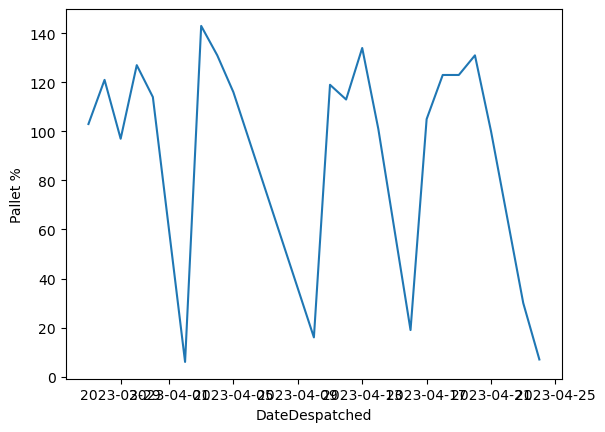

In [44]:
sns.lineplot(x='DateDespatched', y='Pallet %', data=total_daily_pallets)

Creating total daily pallets per area (only-pallets aggregated by day and area). Using daily_pallet_orders

Ideal for decision making.

In [45]:
#Creating daily only-pallets per area df
total_daily_pallets_area = daily_pallet_orders.groupby(by=['DateDespatched', 'Area']).sum()

#Adjusting distance
total_daily_pallets_area['Avg Distance'] = round(total_daily_pallets_area['Distance']/total_daily_pallets_area['Order #'],0)

#Restting index
total_daily_pallets_area = total_daily_pallets_area.reset_index()

#Adding number of customers
total_daily_pallets_area = total_daily_pallets_area.merge(customers_per_area, how='left', on='Area')

#Renaming number of customers
total_daily_pallets_area.rename(columns={'WebsiteID':'# Customers'}, inplace=True)

#Dropping columns
total_daily_pallets_area = total_daily_pallets_area.drop(columns=['OrderID', 'Distance', 'WebsiteID_y'])

#Limiting area
total_daily_pallets_area = total_daily_pallets_area[total_daily_pallets_area['Avg Distance'] < 70]

#Print
total_daily_pallets_area.info()
total_daily_pallets_area.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131 entries, 1 to 827
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DateDespatched  131 non-null    datetime64[ns]
 1   Area            131 non-null    object        
 2   LineWeight      131 non-null    float64       
 3   TotalOrderCM    131 non-null    float64       
 4   Pallet %        131 non-null    float64       
 5   Item #          131 non-null    int64         
 6   Order #         131 non-null    int64         
 7   ProductsExVAT   131 non-null    float64       
 8   DeliveryExVAT   131 non-null    float64       
 9   VAT             131 non-null    float64       
 10  SubTotal        131 non-null    float64       
 11  GrandTotal      131 non-null    float64       
 12  DeliveryCost    131 non-null    float64       
 13  Avg Distance    131 non-null    float64       
 14  # Customers     131 non-null    int64         
dtypes: dat

,DateDespatched,Area,LineWeight,TotalOrderCM,Pallet %,Item #,Order #,ProductsExVAT,DeliveryExVAT,VAT,SubTotal,GrandTotal,DeliveryCost,Avg Distance,# Customers
1,2023-03-27,B1,1415.68,14.90496,8.0,1,1,2475.20,19.99,449.54,2475.20,2697.21,277.11,20.0,77
2,2023-03-27,B6,296.32,6.91200,4.0,1,1,641.76,0.00,128.35,641.76,770.11,129.73,25.0,107
7,2023-03-27,CV,357.88,3.01536,3.0,2,2,1113.94,0.00,222.79,1113.94,1336.73,102.00,18.0,328
36,2023-03-27,WS,888.30,2.29446,1.0,1,1,3816.75,0.00,763.35,3816.75,4580.10,34.46,36.0,147
37,2023-03-27,WV,763.36,6.90412,6.0,2,2,1250.72,19.99,254.14,1250.72,1524.85,207.65,47.0,104


## Costs

Calculating median, mean and difference between them.

Large positive values mean that there are big orders creating distortions in the mean. If negative value, the data has a lot of small values and some larger ones.

In [46]:
avg_daily_orders_per_area = total_daily_pallets_area.groupby(by=['Area']).mean()
avg_daily_orders_per_area.drop(columns=['ProductsExVAT', 'DeliveryExVAT', 'VAT', 'SubTotal', 'GrandTotal', '# Customers'], inplace=True)

median_daily_orders_per_area = total_daily_pallets_area.groupby(by=['Area']).median()
median_daily_orders_per_area.drop(columns=['ProductsExVAT', 'DeliveryExVAT', 'VAT', 'SubTotal', 'GrandTotal', '# Customers'], inplace=True)

comp_daily_pallets_orders_per_area = avg_daily_orders_per_area -  median_daily_orders_per_area
comp_daily_pallets_orders_per_area.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, B1 to WV
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LineWeight    24 non-null     float64
 1   TotalOrderCM  24 non-null     float64
 2   Pallet %      24 non-null     float64
 3   Item #        24 non-null     float64
 4   Order #       24 non-null     float64
 5   DeliveryCost  24 non-null     float64
 6   Avg Distance  24 non-null     float64
dtypes: float64(7)
memory usage: 1.5+ KB


In [47]:
miles_per_day = 160

In [50]:
df_costs.to_csv('df_costs.csv')
df_orders.to_csv('df_orders.csv')
df_orders_pallets_area.to_csv('orders_pallets_area.csv')
df_orders_pallets.to_csv('orders_pallets.csv')
total_daily_pallets_area.to_csv('total_daily_pallets_area.csv')
total_daily_pallets.to_csv('total_daily_pallets.csv')